# BIOEE 4940 : **Introduction to Quantitative Analysis in Ecology**
### ***Spring 2021***
### Instructor: **Xiangtao Xu** ( ✉️ xx286@cornell.edu)
### Teaching Assistant: **Yanqiu (Autumn) Zhou** (✉️ yz399@cornell.edu)

---

## <span style="color:royalblue">Lecture 6</span> *Regression II: Multiple Linear Regressions*
*Partly adapted from [How to be a quantitative ecologist](https://www.researchgate.net/publication/310239832_How_to_be_a_Quantitative_Ecologist_The_'A_to_R'_of_Green_Mathematics_and_Statistics) and [All of Statistics](https://www.stat.cmu.edu/~larry/all-of-statistics/)*


#### 1. Multiple Linear Regression

A variable of interest or measurement can depend on multiple independent/interactive processes (i.e. have multiple covariates). To investigate such relationships, we can simply extend the Simple Linear Regression framework to include multiple explanatory variables.

The regression model becomes $\textbf{Y}=\textbf{X}\beta+\epsilon$. where $\textbf{Y}$ is a vector including observations for the response variable and $\textbf{X}$ is a matrix of observations for all explanatory variables (and 1 if intercept is included). Consequently, $\beta$ is a vector containing all the regression coefficients.

All the assumptions (linearity, normality, homoscedasticity, etc.) of simple linear regression are carried over.


In [ ]:
# import packages and read the data

import pandas as pd
import numpy as np


baad_data_url = 'https://raw.githubusercontent.com/xiangtaoxu/QuantitativeEcology/main/Lab1/baad_data.csv'
baad_dictionary_url = 'https://raw.githubusercontent.com/xiangtaoxu/QuantitativeEcology/main/Lab1/baad_dictionary.csv'

df_data = pd.read_csv(baad_data_url, encoding='latin_1') # can also read local files
df_dict = pd.read_csv(baad_dictionary_url, encoding='latin_1')

# we will consider the relationship between Tree Diameter (d.bh) and Tree Height (h.t)
# first clean the data to only include valid data entries


df_mlm = df_data[['d.bh','h.t','a.lf','r.st','ma.ilf','vegetation','pft']].dropna()

# rename columns to avoid mis-interpreation for formula-based regressions
df_mlm.rename(columns={'d.bh' : 'dbh','h.t' : 'h','a.lf':'la','r.st':'wd','ma.ilf':'lma'},inplace=True)

# scatter plot the data
import matplotlib.pyplot as plt
%matplotlib inline

pd.plotting.scatter_matrix(df_mlm[['la','dbh','h','wd','lma']])

plt.show()

First, let's consider a polynomial regression, one of the simplest multiple regressions, which can be useful to predict (usually empirically) a nonlinear relationship

In [ ]:
import statsmodels.formula.api as smf #StatsModel Formulat api
import statsmodels.api as sm

res_poly = smf.ols('la ~ dbh + np.power(dbh,2)',data=df_mlm).fit()
print(res_poly.summary())

fig,ax = plt.subplots(1,1)

ax.scatter(df_mlm['dbh'],df_mlm['la'])

plot_x = np.linspace(df_mlm['dbh'].min(),df_mlm['dbh'].max(),100)

# need to reverse the order of the coefficients if using numpy polyval
plot_y = np.polyval(res_poly.params[::-1],plot_x)

ax.plot(plot_x,plot_y,'r-')

plt.show()


In [ ]:
# what about 4th order polynomial?

# some pythonic tricks
power_str = [f'np.power(dbh,{i})' for i in range(1,4+1)]
reg_str = 'la ~ ' + ' + '.join(power_str) 

res_poly = smf.ols(reg_str,data=df_mlm).fit()
print(res_poly.summary())

fig,ax = plt.subplots(1,1)

ax.scatter(df_mlm['dbh'],df_mlm['la'])

plot_x = np.linspace(df_mlm['dbh'].min(),df_mlm['dbh'].max(),100)

# need to reverse the order of the coefficients if using numpy polyval
plot_y = np.polyval(res_poly.params[::-1],plot_x)

ax.plot(plot_x,plot_y,'r-')

plt.show()

# what about 5 or even more, what would happen?


Second, we are often interested in the dependence of a response variable to several different explanatory variables.

In [ ]:
# leaf area should be higher for bigger and taller trees, maybe trees with harder wood,
# which can biophysically support more leaves, and trees with thinner leaves.

res_mlm = smf.ols('np.log(la) ~ np.log(dbh) + np.log(h) + np.log(wd) + np.log(lma)',data=df_mlm).fit()
print(res_mlm.summary())

##### Key Model Diagnostics
 
* adjusted $R^2$ or $R^2_{adj}$

$R^2_{adj} = 1 - (1 - R^2)\frac{n-1}{n-p-1}$, where n is the # of samples, p is the # of parameters. 

This is because increases of parameters will reduce the degree of freedom of the residuals. In fact, $R^2_{adj}$ can be rewritten as $1 - \frac{RSS/df_e}{TSS/df_t}$.

From the equation we can see that adjusted R2 will be significantly when n is small, p is large, and R2 is low.

In [ ]:
df_small = df_mlm.sample(20)
res_small = smf.ols('np.log(la) ~ np.log(dbh) + np.log(h) + np.log(wd) + np.log(lma)',data=df_small).fit()
print(res_small.summary())

* residual analysis, partial regression plots, and Component-Component plus Residual (CCPR) Plots

In [ ]:
fig = plt.figure()
sm.graphics.plot_regress_exog(res_mlm, 'np.log(wd)', fig=fig)
fig.tight_layout()

fig = plt.figure()
sm.graphics.plot_regress_exog(res_poly, 'np.power(dbh, 1)', fig=fig)
fig.tight_layout()

* Multi-collinearity and Variance Inflation Factor (VIF)

Multi-collinearity happens when two or more explanatory variables are highly correlated (e.g. dbh and h in our multiple regression for leaf area).

Generally, multi-collinearity is less worrisome if the main purpose of the regression is for prediction (esp. predictions within the range of training data set). However, extra care needs to be taken if the main purpose is to infer causal relationship or sensitivity between processes because multi-collinearity could greatly influence the estimates of regression coefficients (e.g. you can see large changes in parameter coefficient when removing/adding the colinear explanatory variables).


In [ ]:
# example, remove/add height

res_mlm1 = smf.ols('np.log(la) ~ np.log(dbh) + np.log(h) + np.log(wd) + np.log(lma)',data=df_mlm).fit()
print(res_mlm1.summary())

res_mlm2 = smf.ols('np.log(la) ~ np.log(dbh) + np.log(wd) + np.log(lma)',data=df_mlm).fit()
print(res_mlm2.summary())

We can use variance inflaciton factor (VIF) to quantify the degree of multi-collinearity. VIF bascially describes how much one explanatory variable ($X_i$) can be explained by all other explanatory variables. It is calculated as $\frac{1}{1-R_i^2}$, where $R_i^2$ is the R2 value of the regression model with $X_i$ as response variable and all other X variables as explanatory variables.

When VIF is above 5 (10), it suggests that there exists some mild (severe) multicollinearity.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

x_vars = ['dbh','h','wd','lma']
X_data = np.log(df_mlm[x_vars].values)

# Warning, you need to manually add a constant column to represent intercept
# because variance_inflation_factor in python uses sm.OLS which does not include
# the intercept by default...

X_data = np.hstack((X_data,np.ones((X_data.shape[0],1))))

for i, x_var in enumerate(x_vars):
    print(f'{x_var}: VIF = {variance_inflation_factor(X_data,i)}')



While it is easy to detect multicollinearity, the harder question is how to deal with it. Should we remove variables? Shoule we leave them as they are? Here are some general advice:

(1) Check the variables with high linearity and make sure they provide different information/represent different hypotheses in your model (e.g., dbh and h in our model)

(2) Separate your data into smaller subset and use regression model from one subset to predict another (aka cross-validation). This practice helps to estimate the impact of collinearity to out-of-sample predictions

(3) Leave the variables as they are if both of them are significant, which usually mean they provide some degrees of non-overlapping information

(4) Collect new data where the variables are relatively orthorgonal

* Variable Importance

In addition to knowing how good the model is, we sometimes are also interested in how important (which is a rather subjective word!) each variable is. The importance of variables could offer insights to the importance of the underlying processes.

Here is an example of changes in statistical variable importance of determinants in savanna tree cover ([Xu et al. 2018](http://doi.wiley.com/10.1111/geb.12707))

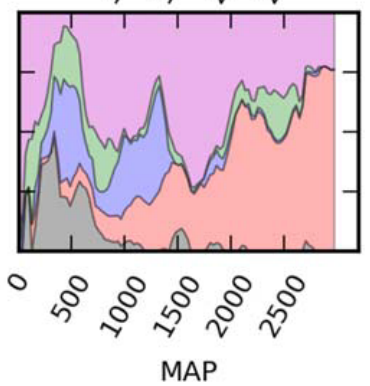

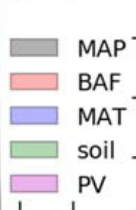


[Grömping 2015](http://doi.wiley.com/10.1002/wics.1346) provides a good summary of different ways to define and estimate variable importance in regression models. Here I am introducing two complementary metrics:

(1) standardardized regression coefficient ($\beta_i s_i / s_Y$). This metric tells us how much standard deviation Y will change for one standard deviation change in $X_i$. Therefore, it tells us the importance based on sensitivity.

(2) sequential increase in explained variance ($R^2$) when introducing the variable. This metric evaluates the importance based on the explanatory power. For example, the importance used in Xu et al. 2018 is described as follow: 

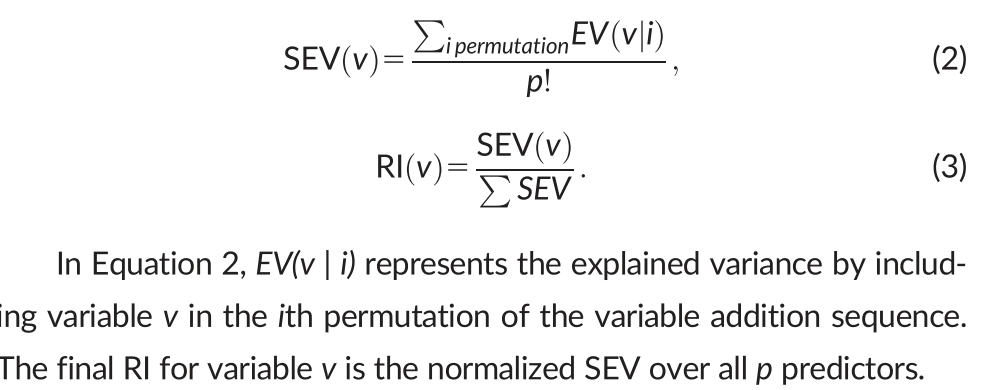

In [ ]:
# only use significant variables
res_vi = smf.ols('np.log(la) ~ np.log(dbh) + np.log(h) + np.log(wd)',data=df_mlm).fit()
print(res_vi.summary())

In [ ]:
var_list = ['dbh','h','wd']

# 1. standardized coef
std_coef = [res_vi.params[i+1] 
            * np.std(np.log(df_mlm[var])) 
            / np.std(np.log(df_mlm['la']))
            for i, var in enumerate(var_list)]
print(std_coef)

In [ ]:
# 2. R2 based importance
var_list = np.array(['np.log(dbh)','np.log(h)','np.log(wd)'])
# use standard python library to get all permutations
from itertools import permutations

permute_array = list(permutations(var_list))
print(permute_array)

var_imp = np.zeros((3,))

for var_seq in permute_array:
    for i in range(1,len(var_seq)+1):
        reg_vars = var_seq[0:i]
        
        
        # find the last variable, search is index in var_list
        last_var = reg_vars[-1]
        var_idx = np.argwhere(var_list == last_var)[0]
        
        # calculate sequential increase in R2
        if len(reg_vars) == 1:
            reg_str = 'np.log(la) ~ ' + ' + '.join(reg_vars)
            sr2 = smf.ols(reg_str,data=df_mlm).fit().rsquared
        else:
            # need to calculate two regressions
            reg_str_curr = 'np.log(la) ~ ' + ' + '.join(reg_vars)
            reg_str_prev = 'np.log(la) ~ ' + ' + '.join(reg_vars[0:-1])
            
            sr2 = ( smf.ols(reg_str_curr,data=df_mlm).fit().rsquared
                   -smf.ols(reg_str_prev,data=df_mlm).fit().rsquared)
        
        # store the sR2
        
        var_imp[var_idx] += sr2
        
# normalize var_imp
var_imp = var_imp / sum(var_imp)
print(var_imp)
        

#### 2. Categorical variables in Multiple Regression

This application is equivalent of ANOVA analysis

In [ ]:
# need to create a new data frame with both DA and EA...
df_cat = df_data[['vegetation','pft','m.lf','m.rf']]
df_cat.dropna(inplace=True)
df_cat.rename(columns={'m.lf' : 'lm', 'm.rf' : 'rm'},inplace=True)
df_cat['l2r'] = df_cat['lm'] / df_cat['rm']

# select only sav, tropRF, tropSF, tempF
df_cat = df_cat[df_cat['vegetation'].isin(['Sav','TropRF','TropSF','TempF'])]
# select only DA and EA
df_cat = df_cat[df_cat['pft'].isin(['DA','EA'])]


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
df_cat.boxplot('l2r',by=['vegetation','pft'],ax=ax)
fig.tight_layout()
plt.show()


In [ ]:
res_l2r = smf.ols('np.log(l2r) ~ C(vegetation)',data=df_cat).fit()

print(res_l2r.summary())
print(sm.stats.anova_lm(res_l2r))

# overlapping CI does not necessarily mean non-significant difference

#
# do a multiple comparison
MultiComp = sm.stats.multicomp.MultiComparison(np.log(df_cat['l2r']),df_cat['vegetation'])
print(MultiComp.tukeyhsd())

In [ ]:
# Multiple groups (two-way anova)

res_l2r = smf.ols('np.log(l2r) ~ C(vegetation) * C(pft)',data=df_cat).fit()
print(res_l2r.summary())
print(sm.stats.anova_lm(res_l2r))


#### 3. Interactive terms and mixed effect model

* Interaction Effects

In basic multiple linear models, we assume all explanatory variables are all independent from each other. In reality, different processes can interact to determine the response variable. For instance, in our regression model to predict leaf area, increases of leaf area with plant size (dbh, h, etc.) can also depend on plant functional traits, such as wood density and leaf mass per area. That means there exist interaction effects between traits and size.

To account for such interactions, we can include interactive terms in the regression models.

In [ ]:
# let's consider a simple case, only dbh and wd are considered and we add an interactive term between dbh and wd
res_int = smf.ols('np.log(la) ~ np.log(dbh) + np.log(wd) + np.log(dbh) : np.log(wd)',data=df_mlm).fit()
# or 'np.log(la) ~ np.log(dbh) * np.log(wd)'
print(res_int.summary())

res_noint = smf.ols('np.log(la) ~ np.log(dbh) + np.log(wd)',data=df_mlm).fit()
print(res_noint.summary())

In [ ]:
# categorical variables can also be used for interactive effects
res_int_cat = smf.ols('np.log(la) ~ np.log(dbh) * C(pft)',data=df_mlm).fit()
print(res_int_cat.summary())

* Linear Mixed Model

When the interaction effect contains one or more categorical variable, it usually means the data/process has some sort of struture. In this case, we can usually apply a linear mixed model (LMM).

More specifically, LMMs are designed to analyze multilevel/hierarchical data. Such data set are usually not fully independent from each other. This is particuarly common in ecological studies such as samplings from different species, plots, censuses, spatial grid cells, etc. Observations from individuals within a species or within a same plot are likely to be more similar compared with individuals across species/plots. Therefore, we can assume the variance across the highest level of the data is independent but not the variance within each level.

One naive way to deal with the hierarchical data is to aggregate information to the highest level where variance is likley independent (e.g. use species-average trait). However, this does not really take advantage of all the data.

Another approach is to analyze each category every time. This means running a regression for e.g. each species. However, the results are hard to interpret and each regression does not take advantage of data from other groups, especially when we are looking for some general relationship across the groups.

LMM goes somewhere in between. It introduces two effects: (1) **fixed effects** denote the shared relationship/regression coef across all levels/groups, and (2) **random effects** denote the stochastic part of the regression coef beyond the fixed effects, which account for variations across groups.

Another important reason of using LMM is to get away with the Simpson's Paradox, where within-group relationship is inverse from the cross-group relationship

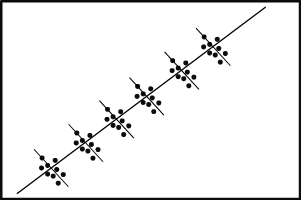!

[source: UCLA stats](https://stats.idre.ucla.edu/other/mult-pkg/introduction-to-linear-mixed-models/)

The *first* common usage of LMM is **random intercepts/slopes models**. As suggested from its name, it accounts for the random effects in the intercept or slopes

A simple example of the model can be written as

$Y_{ij} = \beta_0 + \beta_1X_{ij} + \gamma_{0i} + \gamma_{1i}X_{ij} + \epsilon_{ij}$

Here, $i$ indicates different groups and j indicates the $j$th observation from group i. $\beta_0$ and $\beta_1$ are fixed effects while $\gamma_{0i}$ and ${\gamma_{1i}}$ are random effects. From the equation, we can already see its linkage with interaction effects in multiple linear models.

In [ ]:
df_lmm = df_data[['d.bh','h.t','r.st','vegetation','pft','location','species','family']].dropna()

# rename columns to avoid mis-interpreation for formula-based regressions
df_lmm.rename(columns={'d.bh' : 'dbh','h.t' : 'h','r.st':'wd'},inplace=True)


In [ ]:
# ols
res_ols = smf.ols('np.log(h) ~ np.log(dbh)',data=df_lmm).fit()
print(res_ols.summary())


# random intercept
res_lmm_ri = smf.mixedlm('np.log(h) ~ np.log(dbh)',re_formula='1',groups=df_lmm['family'],data=df_lmm).fit()
print(res_lmm_ri.summary())

# random slope
res_lmm_rs = smf.mixedlm('np.log(h) ~ np.log(dbh)',re_formula='0+np.log(dbh)',groups=df_lmm['family'],data=df_lmm).fit()
print(res_lmm_rs.summary())

# random intercept and slope
res_lmm = smf.mixedlm('np.log(h) ~ np.log(dbh)',re_formula='1+np.log(dbh)',groups=df_lmm['family'],data=df_lmm).fit()
print(res_lmm.summary())


In [ ]:
print(res_lmm.random_effects)
re_int = [res_lmm.random_effects[var][0] for var in res_lmm.random_effects.keys()]
re_slo = [res_lmm.random_effects[var][1] for var in res_lmm.random_effects.keys()]

fig = plt.figure()
plt.scatter(re_int,re_slo)
plt.show()

*Second*, LMM can be used to partition variance across multiple levels (**variance components**, see example below). 

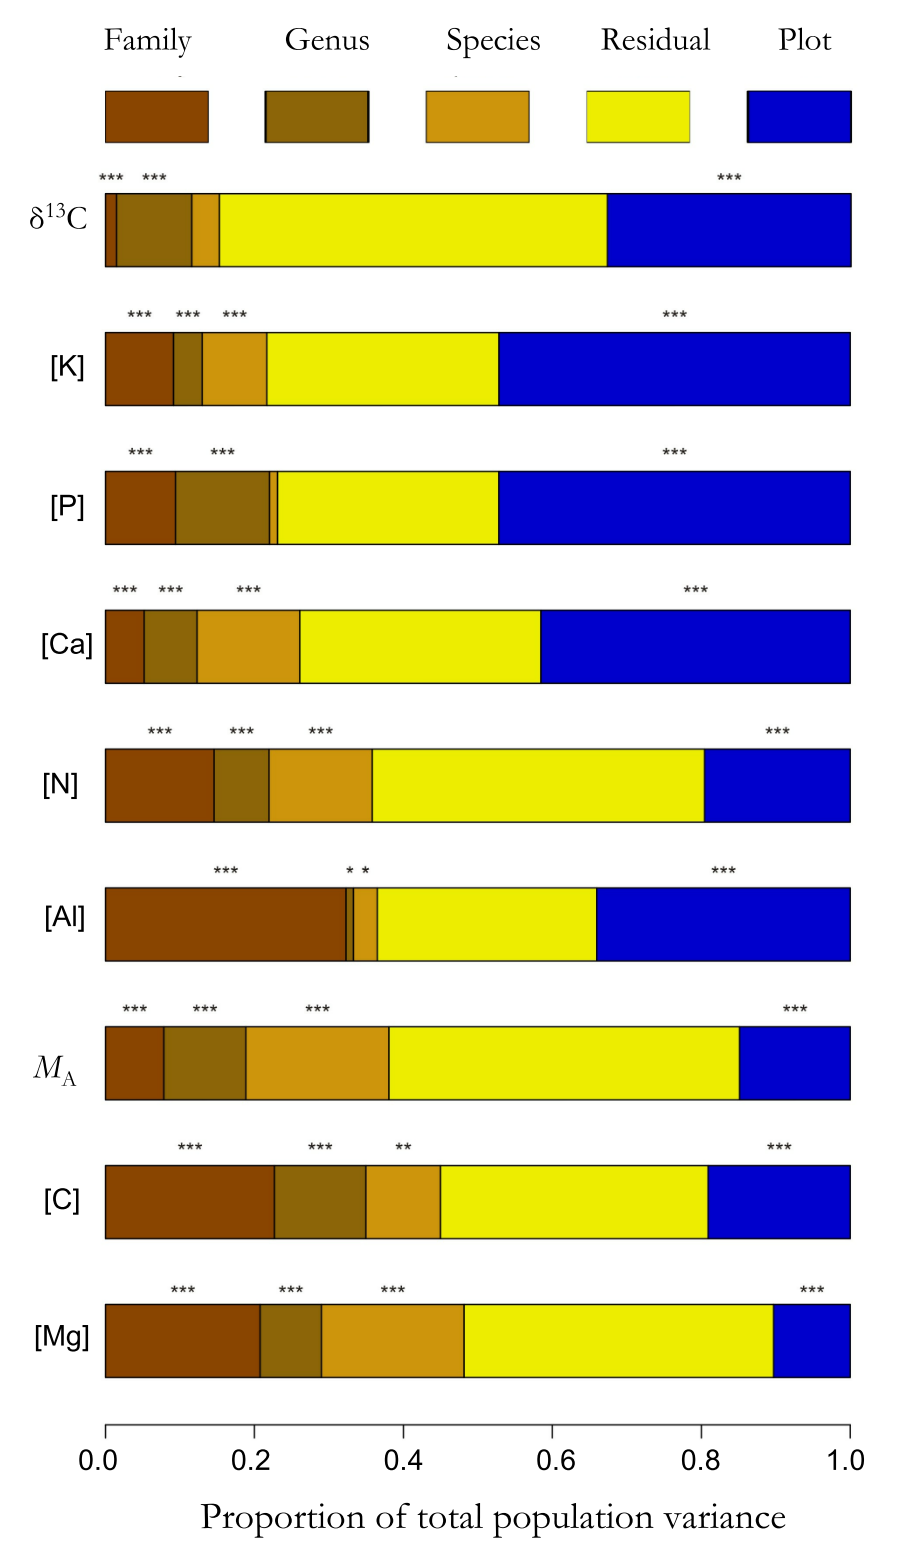

source: [Fyllas et al. 2012](http://www.biogeosciences.net/6/2677/2009/bg-6-2677-2009.pdf)


A simple case can be written as

$Y_{ijk} = \beta_0 + \eta_{1i} + \eta_{2j} + \epsilon_{ijk}$

Here, $Y_{ijk}$ indciates the kth measurement under condition i,j. THere is only one fixed effect $\beta_0$ denoting the average level of Y. $\eta$ indicates the random effects associated with each condition.


In [ ]:
# partition the variance of LL
# R has a similar package lme4
df_lmm['group'] = 0 # a dummy variable
vc={'f' : '0 + C(family)',
    's' : '0 + C(species)',
    'loc' : '0 + C(location)',
    }
res_vp = smf.mixedlm('np.log(wd) ~ 1',vc_formula=vc,groups=df_lmm['group'],data=df_lmm).fit()
print(res_vp.summary())
print(res_vp.random_effects)


#### Summary/Discussion

* Interpreation of Multiple Linear Regression results
* Collinearity/Interaction
* When to use Linear Mixed Models